In [2]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from src.path_loss import PathLossInHIndoorOffice, PathLossInHShoppingMalls
from src.network_sim import NetworkSimulator
from src.algorithm import wmmse
from src.sc import SyntheticControl

%reload_ext autoreload
%autoreload 2
%aimport src

In [3]:
frequency_Hz= 50 * 1e9 # Hz
distance_m = 50
sample_size = 10

In [4]:
pd.DataFrame({
    'PathLossInHIndoorOffice':[PathLossInHIndoorOffice().in_dBm(frequency_Hz=frequency_Hz, distance_m=distance_m) for i in range(sample_size)],
    'PathLossInHShoppingMalls': [PathLossInHShoppingMalls().in_dBm(frequency_Hz=frequency_Hz, distance_m=distance_m) for i in range(sample_size)],
})

,PathLossInHIndoorOffice,PathLossInHShoppingMalls
0,-125.549711,-102.680151
1,-135.884556,-113.660575
2,-119.117274,-102.456709
3,-133.794549,-117.690479
4,-129.868340,-110.447279
5,-114.536864,-95.923689
6,-126.399550,-108.244133
7,-125.855869,-100.564212
8,-124.537846,-102.473276
9,-116.856493,-102.112441


In [5]:
simulator = NetworkSimulator(Tx_radius=100, Rx_radius=25, num_Tx_known=1, num_Rx_per_Tx_known=10, num_Tx_unknown=1, num_Rx_per_Tx_unknown=10)

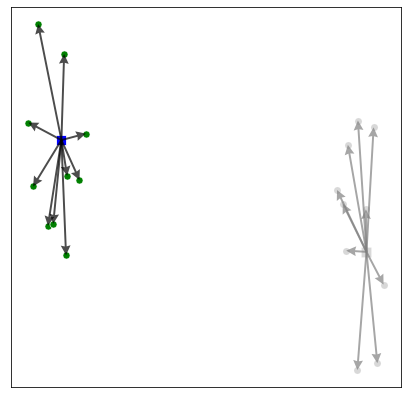

In [6]:
simulator.plot_network()

In [7]:
pd.DataFrame(simulator.gain_mat_dBm)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-83.935150,-87.438569,-101.644159,-92.862606,-99.832998,-87.009904,-83.228192,-91.526474,-108.941911,-92.523639,-144.527044,-138.538930,-123.342965,-136.244198,-136.556720,-136.279394,-123.726507,-129.396797,-137.527936,-144.195578
1,-136.808899,-148.138077,-146.776526,-133.053754,-142.477072,-132.410640,-145.042712,-132.714197,-142.904871,-145.166157,-92.282985,-110.274318,-85.909990,-86.624603,-109.241198,-104.890622,-96.427568,-89.807299,-90.774736,-92.279791


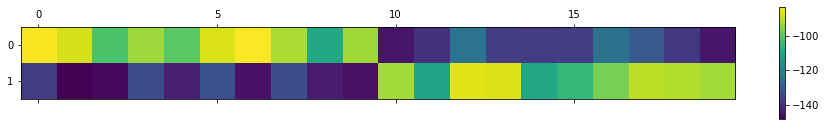

In [8]:
simulator.plot_gain_mat()

In [9]:
simulator.weighted_sum_rate_Gnats(Rx_powers_mW=[250 for i in range(len(simulator.x_Rx))], Rx_weights=np.ones(len(simulator.x_Rx)))

459.6286388511677

In [10]:
part = 'known'
gain_mat_mW = simulator.get_gain_mat(part=part, unit='mW')

if part == 'unknown':
    Tx_idx_shift = len(simulator.x_Tx) - gain_mat_mW.shape[0]
    Rx_idx_shift = len(simulator.x_Rx) - gain_mat_mW.shape[1]
else:
    Tx_idx_shift = 0
    Rx_idx_shift = 0

Rx_powers_mW = np.random.uniform(1, 10, len(simulator.x_Rx))

wmmse(
    simulator = simulator, 
    gain_mat_mW = gain_mat_mW,
    Rx_powers_mW = Rx_powers_mW,
    Rx_max_powers_mW = [500 for i in range(gain_mat_mW.shape[1])],
    Rx_weights=np.ones(len(simulator.x_Rx)),
    Tx_idx_shift=Tx_idx_shift,
    Rx_idx_shift=Rx_idx_shift,
    max_iter=5000,
)

Weighted Sum Rate: 436.06697735326446 Convergence Error at Round 5000 0.0


array([  0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
       500.        ,   0.        ,   5.19426649,   4.44800266,
         6.33869419,   8.72002109,   7.84425772,   8.63391374,
         5.40147292,   9.27119344,   9.79152203,   1.03861666])

In [11]:
power_corr_mat = np.random.uniform(0.5, 1.5, 
    (simulator.num_Tx_unknown*simulator.num_Rx_per_Tx_unknown, 
     simulator.num_Tx_known*simulator.num_Rx_per_Tx_known)
)
power_corr_mat

array([[1.02774811, 0.98980082, 1.13928395, 0.97034394, 0.65612304,
        1.3120444 , 1.37356589, 1.47292901, 0.7619209 , 0.93435526],
       [1.42718554, 0.89706046, 1.2684339 , 0.76635752, 1.40875801,
        1.28273898, 1.33423547, 0.88425834, 0.5879053 , 1.13830117],
       [0.52437894, 0.99042901, 0.86498628, 1.44229046, 1.24279852,
        0.78577623, 1.34259631, 0.904224  , 1.32917911, 0.85290883],
       [1.16531383, 0.6430627 , 1.44160235, 0.95960193, 1.34731373,
        1.16078308, 1.33299928, 1.12521674, 0.80606805, 1.34701168],
       [0.94259288, 1.25937995, 0.81465326, 1.27874933, 1.00420181,
        0.50374981, 0.97811014, 1.09644351, 0.85914576, 1.48571175],
       [0.55599726, 0.52333722, 1.35781073, 1.49018601, 0.8951454 ,
        0.6915028 , 0.76802966, 0.9810691 , 0.60383958, 1.38804253],
       [0.82306376, 0.69838194, 1.06629003, 0.90840581, 1.43638902,
        0.82520285, 0.76702398, 0.65448253, 0.66086625, 1.41127174],
       [1.24804766, 0.8612114 , 1.061448 

In [43]:
observed_interferences_list = []
for p_known in [np.random.uniform(0,500, gain_mat_mW.shape[1]) for i in range(50)]:
    p_unknown = power_corr_mat.dot(p_known)
    p = np.append(p_known, p_unknown)
    observed_interference = simulator.Rx_interference(p)[Rx_idx_shift: Rx_idx_shift+gain_mat_mW.shape[1]]
    observed_interferences_list.append(observed_interference)

In [44]:
sc = []
for i in range(len(simulator.x_Rx) - gain_mat_mW.shape[1]):
    sc_data = pd.DataFrame(observed_interferences_list) * 1e11
    sc_train_X = sc_data.drop(i, axis=1)
    sc_train_y = sc_data[i] 
    sc_i = SyntheticControl().fit(X=sc_train_X, y=sc_train_y)
    sc.append(sc_i)

In [45]:
sc_data.head(5)

,0,1,2,3,4,5,6,7,8,9
0,59.080988,4.350408,5.952303,140.269182,16.018817,162.657330,8.872919,151.676406,14.516120,8.624263
1,48.702428,3.586186,4.906682,115.628562,13.204845,134.083858,7.314243,125.031918,11.966122,7.109267
2,62.283341,4.586212,6.274934,147.872159,16.887081,171.473806,9.353855,159.897687,15.302934,9.091722
3,43.258785,3.185346,4.358245,102.704349,11.728893,119.096832,6.496704,111.056658,10.628626,6.314639
4,55.720188,4.102937,5.613709,132.290021,15.107592,153.404627,8.368186,143.048350,13.690376,8.133675


In [58]:
check_Rx = 9
p_known = [50 for i in range(gain_mat_mW.shape[1])]
p_unknown = power_corr_mat.dot(p_known[Rx_idx_shift: Rx_idx_shift+gain_mat_mW.shape[1]])
p = np.append(p_known, p_unknown)
observed_interferences = simulator.Rx_interference(p)[Rx_idx_shift: Rx_idx_shift+gain_mat_mW.shape[1]]
print('Real Interferences:', observed_interferences[check_Rx])
print('SC Interference', sc[check_Rx].predict(pd.DataFrame(observed_interferences).drop(check_Rx, axis=0)[0]))
print(p_known, p_unknown)

Real Interferences: 1.534385472582352e-11
SC Interference 1.5343851824437012e-11
[50, 50, 50, 50, 50, 50, 50, 50, 50, 50] [531.90576575 549.76173402 513.97838448 566.44866851 511.13690998
 462.74801426 462.56889585 492.57516053 496.1328918  454.13215213]


[30, 30, 30, 30, 30, 30, 30, 30, 30, 30] [319.14345945 329.85704041 308.38703069 339.86920111 306.68214599
 277.64880856 277.54133751 295.54509632 297.67973508 272.47929128]


In [235]:
sc[0].coef_

array([0.11111111, 0.11111111, 0.11111111, 0.11111111, 0.11111111,
       0.11111111, 0.11111111, 0.11111111, 0.11111111])

In [182]:
pd.DataFrame(interferences_list)

,0,1
0,7.456463e-10,1.610943e-10
1,2.319765e-09,5.455820e-10
2,2.005248e-09,4.594665e-10
3,2.417994e-09,5.494061e-10
4,1.627052e-09,3.620518e-10
...,...,...
495,1.860165e-09,4.008460e-10
496,2.142029e-09,4.933615e-10
497,1.491186e-09,3.328793e-10
498,1.852419e-09,4.246364e-10


In [234]:
i = 5
sc[i].mse / observed_interferences[i]

1.403759419951393

In [184]:
p

array([20.        , 20.        , 47.24219135])

In [185]:
power_corr_mat

array([[0.93465383, 1.42745574]])

In [201]:
simulator.Rx_interference([50,0,0])

[0.0, 3.538825118782888e-11, 6.570757626109276e-10]